# Practice Lab: Advice for Applying Machine Learning
In this lab, you will explore techniques to evaluate and improve your machine learning models.

# Outline
- [ 1 - Packages ](#1)
- [ 2 - Evaluating a Learning Algorithm (Polynomial Regression)](#2)
  - [ 2.1 Splitting your data set](#2.1)
  - [ 2.2 Error calculation for model evaluation, linear regression](#2.2)
    - [ Exercise 1](#ex01)
  - [ 2.3 Compare performance on training and test data](#2.3)
- [ 3 - Bias and Variance<img align="Right" src="./images/C2_W3_BiasVarianceDegree.png"  style=" width:500px; padding: 10px 20px ; "> ](#3)
  - [ 3.1 Plot Train, Cross-Validation, Test](#3.1)
  - [ 3.2 Finding the optimal degree](#3.2)
  - [ 3.3 Tuning Regularization.](#3.3)
  - [ 3.4 Getting more data: Increasing Training Set Size (m)](#3.4)
- [ 4 - Evaluating a Learning Algorithm (Neural Network)](#4)
  - [ 4.1 Data Set](#4.1)
  - [ 4.2 Evaluating categorical model by calculating classification error](#4.2)
    - [ Exercise 2](#ex02)
- [ 5 - Model Complexity](#5)
  - [ Exercise 3](#ex03)
  - [ 5.1 Simple model](#5.1)
    - [ Exercise 4](#ex04)
- [ 6 - Regularization](#6)
  - [ Exercise 5](#ex05)
- [ 7 - Iterate to find optimal regularization value](#7)
  - [ 7.1 Test](#7.1)


_**NOTE:** To prevent errors from the autograder, you are not allowed to edit or delete non-graded cells in this notebook . Please also refrain from adding any new cells. 
**Once you have passed this assignment** and want to experiment with any of the non-graded code, you may follow the instructions at the bottom of this notebook._

<a name="1"></a>
## 1 - Packages 

First, let's run the cell below to import all the packages that you will need during this assignment.
- [numpy](https://numpy.org/) is the fundamental package for scientific computing Python.
- [matplotlib](http://matplotlib.org) is a popular library to plot graphs in Python.
- [scikitlearn](https://scikit-learn.org/stable/) is a basic library for data mining
- [tensorflow](https://www.tensorflow.org/) a popular platform for machine learning.

In [1]:
import numpy as np
# %matplotlib widget
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

from public_tests_a1 import * 

tf.keras.backend.set_floatx('float64')
from assigment_utils import *

tf.autograph.set_verbosity(0)

C:\Users\vach04\PycharmProjects\machine_learning_course\advanced_learning_algorithms\Week3Assignment\assigment_utils.py:144: SyntaxWarning: invalid escape sequence '\l'
  ax[0].plot(x, y_pred[:,i],  lw=0.5, label=f"$\lambda =${lambda_range[i]}")


<a name="2"></a>
## 2 - Evaluating a Learning Algorithm (Polynomial Regression)

<img align="Right" src="./images/C2_W3_TrainingVsNew.png"  style=" width:350px; padding: 10px 20px ; "> Let's say you have created a machine learning model and you find it *fits* your training data very well. You're done? Not quite. The goal of creating the model was to be able to predict values for <span style="color:blue">*new* </span> examples. 

How can you test your model's performance on new data before deploying it?   
The answer has two parts:
* Split your original data set into "Training" and "Test" sets. 
    * Use the training data to fit the parameters of the model
    * Use the test data to evaluate the model on *new* data
* Develop an error function to evaluate your model.

<a name="2.1"></a>
### 2.1 Splitting your data set
Lectures advised reserving 20-40% of your data set for testing. Let's use an `sklearn` function [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to perform the split. Double-check the shapes after running the following cell.

In [2]:
# Generate some data
X,y,x_ideal,y_ideal = gen_data(18, 2, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

#split the data using sklearn routine 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (18,) y.shape (18,)
X_train.shape (12,) y_train.shape (12,)
X_test.shape (6,) y_test.shape (6,)


#### 2.1.1 Plot Train, Test sets
You can see below the data points that will be part of training (in red) are intermixed with those that the model is not trained on (test). This particular data set is a quadratic function with noise added. The "ideal" curve is shown for reference.

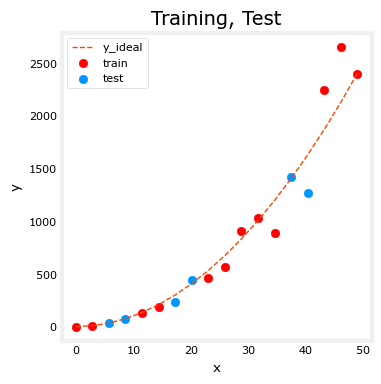

In [3]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.show()

<a name="2.2"></a>
### 2.2 Error calculation for model evaluation, linear regression
When *evaluating* a linear regression model, you average the squared error difference of the predicted values and the target values.

$$ J_\text{test}(\mathbf{w},b) = 
            \frac{1}{2m_\text{test}}\sum_{i=0}^{m_\text{test}-1} ( f_{\mathbf{w},b}(\mathbf{x}^{(i)}_\text{test}) - y^{(i)}_\text{test} )^2 
            \tag{1}
$$

<a name="ex01"></a>
### Exercise 1

Below, create a function to evaluate the error on a data set for a linear regression model.

In [4]:
# UNQ_C1
# GRADED CELL: eval_mse
def eval_mse(y, yhat):
    """ 
    Calculate the mean squared error on a data set.
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:
      err: (scalar)             
    """
    m = len(y)
    err = 0.0
    for i in range(m):
    ### START CODE HERE ### 
        err += (y[i] - yhat[i]) ** 2
        
    
    ### END CODE HERE ### 
    err /= (2*m)
    return(err)

In [5]:
y_hat = np.array([2.4, 4.2])
y_tmp = np.array([2.3, 4.1])
eval_mse(y_hat, y_tmp)

# BEGIN UNIT TEST
test_eval_mse(eval_mse)   
# END UNIT TEST

 All tests passed.


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>

    
```python
def eval_mse(y, yhat):
    """ 
    Calculate the mean squared error on a data set.
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:
      err: (scalar)             
    """
    m = len(y)
    err = 0.0
    for i in range(m):
        err_i  = ( (yhat[i] - y[i])**2 ) 
        err   += err_i                                                                
    err = err / (2*m)                    
    return(err)
``` 

<a name="2.3"></a>
### 2.3 Compare performance on training and test data
Let's build a high degree polynomial model to minimize training error. This will use the linear_regression functions from `sklearn`. The code is in the imported utility file if you would like to see the details. The steps below are:
* create and fit the model. ('fit' is another name for training or running gradient descent).
* compute the error on the training data.
* compute the error on the test data.

In [6]:
# create a model in sklearn, train on training data
degree = 10
lmodel = lin_model(degree)
lmodel.fit(X_train, y_train)

# predict on training data, find training error
yhat = lmodel.predict(X_train)
err_train = lmodel.mse(y_train, yhat)

# predict on test data, find error
yhat = lmodel.predict(X_test)
err_test = lmodel.mse(y_test, yhat)

The computed error on the training set is substantially less than that of the test set. 

In [7]:
print(f"training err {err_train:0.2f}, test err {err_test:0.2f}")

training err 58.01, test err 171215.01


The following plot shows why this is. The model fits the training data very well. To do so, it has created a complex function. The test data was not part of the training and the model does a poor job of predicting on this data.  
This model would be described as 1) is overfitting, 2) has high variance 3) 'generalizes' poorly.

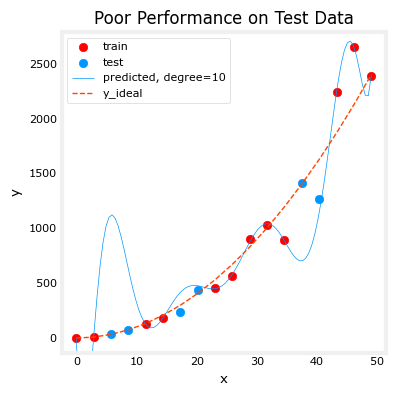

In [8]:
# plot predictions over data range 
x = np.linspace(0,int(X.max()),100)  # predict values for plot
y_pred = lmodel.predict(x).reshape(-1,1)

plt_train_test(X_train, y_train, X_test, y_test, x, y_pred, x_ideal, y_ideal, degree)

The test set error shows this model will not work well on new data. If you use the test error to guide improvements in the model, then the model will perform well on the test data... but the test data was meant to represent *new* data.
You need yet another set of data to test new data performance.

The proposal made during lecture is to separate data into three groups. The distribution of training, cross-validation and test sets shown in the below table is a typical distribution, but can be varied depending on the amount of data available.

| data             | % of total | Description |
|------------------|:----------:|:---------|
| training         | 60         | Data used to tune model parameters $w$ and $b$ in training or fitting |
| cross-validation | 20         | Data used to tune other model parameters like degree of polynomial, regularization or the architecture of a neural network.|
| test             | 20         | Data used to test the model after tuning to gauge performance on new data |


Let's generate three data sets below. We'll once again use `train_test_split` from `sklearn` but will call it twice to get three splits:

In [9]:
# Generate  data
X,y, x_ideal,y_ideal = gen_data(40, 5, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

#split the data using sklearn routine 
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.40, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.50, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_cv.shape", X_cv.shape, "y_cv.shape", y_cv.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (40,) y.shape (40,)
X_train.shape (24,) y_train.shape (24,)
X_cv.shape (8,) y_cv.shape (8,)
X_test.shape (8,) y_test.shape (8,)


<a name="3"></a>
## 3 - Bias and Variance<img align="Right" src="./images/C2_W3_BiasVarianceDegree.png"  style=" width:500px; padding: 10px 20px ; "> 
 Above, it was clear the degree of the polynomial model was too high. How can you choose a good value? It turns out, as shown in the diagram, the training and cross-validation performance can provide guidance. By trying a range of degree values, the training and cross-validation performance can be evaluated. As the degree becomes too large, the cross-validation performance will start to degrade relative to the training performance. Let's try this on our example.

<a name="3.1"></a>
### 3.1 Plot Train, Cross-Validation, Test
You can see below the datapoints that will be part of training (in red) are intermixed with those that the model is not trained on (test and cv).

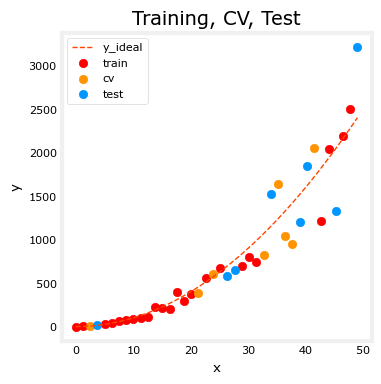

In [10]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, CV, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_cv, y_cv,       color = dlc["dlorange"], label="cv")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.show()

<a name="3.2"></a>
### 3.2 Finding the optimal degree
In previous labs, you found that you could create a model capable of fitting complex curves by utilizing a polynomial (See Course1, Week2 Feature Engineering and Polynomial Regression Lab).  Further, you demonstrated that by increasing the *degree* of the polynomial, you could *create* overfitting. (See Course 1, Week3, Over-Fitting Lab). Let's use that knowledge here to test our ability to tell the difference between over-fitting and under-fitting.

Let's train the model repeatedly, increasing the degree of the polynomial each iteration. Here, we're going to use the [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) linear regression model for speed and simplicity.

In [11]:
max_degree = 9
err_train = np.zeros(max_degree)    
err_cv = np.zeros(max_degree)      
x = np.linspace(0,int(X.max()),100)  
y_pred = np.zeros((100,max_degree))  #columns are lines to plot

for degree in range(max_degree):
    lmodel = lin_model(degree+1)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[degree] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[degree] = lmodel.mse(y_cv, yhat)
    y_pred[:,degree] = lmodel.predict(x)
    
optimal_degree = np.argmin(err_cv)+1

<font size="4">Let's plot the result:</font>

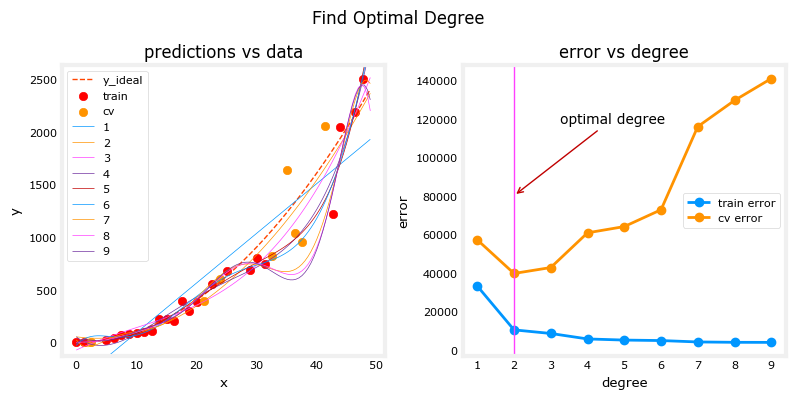

In [12]:
plt.close("all")
plt_optimal_degree(X_train, y_train, X_cv, y_cv, x, y_pred, x_ideal, y_ideal, 
                   err_train, err_cv, optimal_degree, max_degree)

The plot above demonstrates that separating data into two groups, data the model is trained on and data the model has not been trained on, can be used to determine if the model is underfitting or overfitting. In our example, we created a variety of models varying from underfitting to overfitting by increasing the degree of the polynomial used. 
- On the left plot, the solid lines represent the predictions from these models. A polynomial model with degree 1 produces a straight line that intersects very few data points, while the maximum degree hews very closely to every data point. 
- on the right:
    - the error on the trained data (blue) decreases as the model complexity increases as expected
    - the error of the cross-validation data decreases initially as the model starts to conform to the data, but then increases as the model starts to over-fit on the training data (fails to *generalize*).     
    
It's worth noting that the curves in these examples as not as smooth as one might draw for a lecture. It's clear the specific data points assigned to each group can change your results significantly. The general trend is what is important.

<a name="3.3"></a>
### 3.3 Tuning Regularization.
In previous labs, you have utilized *regularization* to reduce overfitting. Similar to degree, one can use the same methodology to tune the regularization parameter lambda ($\lambda$).

Let's demonstrate this by starting with a high degree polynomial and varying the regularization parameter.

In [13]:
lambda_range = np.array([0.0, 1e-6, 1e-5, 1e-4,1e-3,1e-2, 1e-1,1,10,100])
num_steps = len(lambda_range)
degree = 10
err_train = np.zeros(num_steps)    
err_cv = np.zeros(num_steps)       
x = np.linspace(0,int(X.max()),100) 
y_pred = np.zeros((100,num_steps))  #columns are lines to plot

for i in range(num_steps):
    lambda_= lambda_range[i]
    lmodel = lin_model(degree, regularization=True, lambda_=lambda_)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[i] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[i] = lmodel.mse(y_cv, yhat)
    y_pred[:,i] = lmodel.predict(x)
    
optimal_reg_idx = np.argmin(err_cv) 

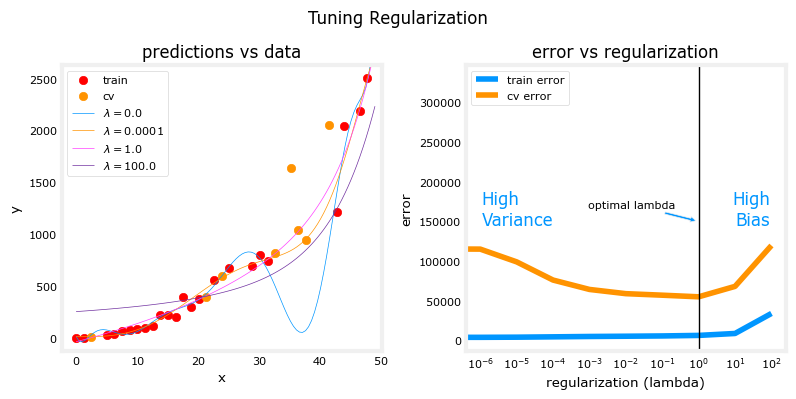

In [14]:
plt.close("all")
plt_tune_regularization(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, optimal_reg_idx, lambda_range)

Above, the plots show that as regularization increases, the model moves from a high variance (overfitting) model to a high bias (underfitting) model. The vertical line in the right plot shows the optimal value of lambda. In this example, the polynomial degree was set to 10. 

<a name="3.4"></a>
### 3.4 Getting more data: Increasing Training Set Size (m)
When a model is overfitting (high variance), collecting additional data can improve performance. Let's try that here.

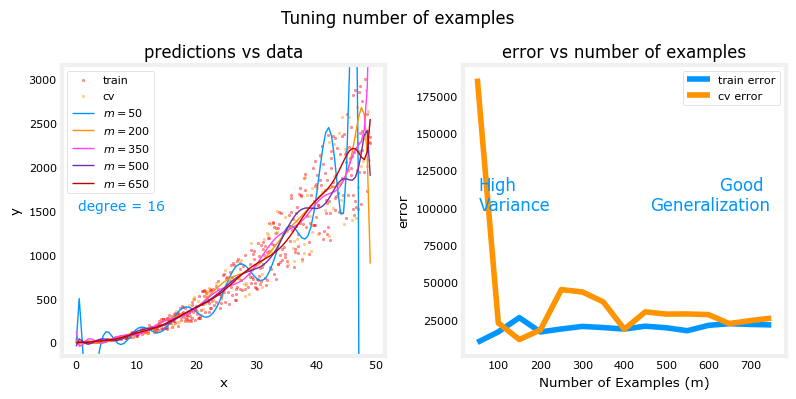

In [15]:
X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range,degree = tune_m()
plt_tune_m(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree)

The above plots show that when a model has high variance and is overfitting, adding more examples improves performance. Note the curves on the left plot. The final curve with the highest value of $m$ is a smooth curve that is in the center of the data. On the right, as the number of examples increases, the performance of the training set and cross-validation set converge to similar values. Note that the curves are not as smooth as one might see in a lecture. That is to be expected. The trend remains clear: more data improves generalization. 

> Note that adding more examples when the model has high bias (underfitting) does not improve performance.


<a name="4"></a>
## 4 - Evaluating a Learning Algorithm (Neural Network)
Above, you tuned aspects of a polynomial regression model. Here, you will work with a neural network model. Let's start by creating a classification data set. 

<a name="4.1"></a>
### 4.1 Data Set
Run the cell below to generate a data set and split it into training, cross-validation (CV) and test sets. In this example, we're increasing the percentage of cross-validation data points for emphasis.  

In [16]:
# Generate and split data set
X, y, centers, classes, std = gen_blobs()

# split the data. Large CV population for demonstration
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.50, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.20, random_state=1)
print("X_train.shape:", X_train.shape, "X_cv.shape:", X_cv.shape, "X_test.shape:", X_test.shape)

X_train.shape: (400, 2) X_cv.shape: (320, 2) X_test.shape: (80, 2)


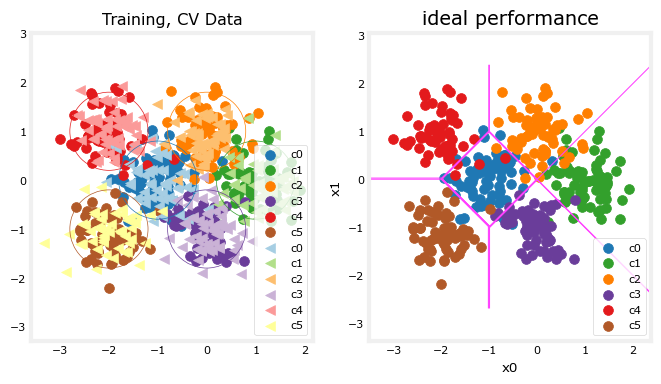

In [17]:
plt_train_eq_dist(X_train, y_train,classes, X_cv, y_cv, centers, std)

Above, you can see the data on the left. There are six clusters identified by color. Both training points (dots) and cross-validataion points (triangles) are shown. The interesting points are those that fall in ambiguous locations where either cluster might consider them members. What would you expect a neural network model to do? What would be an example of overfitting? underfitting?  
On the right is an example of an 'ideal' model, or a model one might create knowing the source of the data. The lines represent 'equal distance' boundaries where the distance between center points is equal. It's worth noting that this model would "misclassify" roughly 8% of the total data set.

<a name="4.2"></a>
### 4.2 Evaluating categorical model by calculating classification error
The evaluation function for categorical models used here is simply the fraction of incorrect predictions:  
$$ J_{cv} =\frac{1}{m}\sum_{i=0}^{m-1} 
\begin{cases}
    1, & \text{if $\hat{y}^{(i)} \neq y^{(i)}$}\\
    0, & \text{otherwise}
\end{cases}
$$

<a name="ex02"></a>
### Exercise 2

Below, complete the routine to calculate classification error. Note, in this lab, target values are the index of the category and are not [one-hot encoded](https://en.wikipedia.org/wiki/One-hot).

In [18]:
# UNQ_C2
# GRADED CELL: eval_cat_err
def eval_cat_err(y, yhat):
    """ 
    Calculate the categorization error
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:|
      cerr: (scalar)             
    """
    m = len(y)
    incorrect = 0
    for i in range(m):
    ### START CODE HERE ### 
       incorrect += 0 if y[i] == yhat[i] else 1
            
    
    ### END CODE HERE ### 
    cerr = incorrect / m
    return(cerr)

In [19]:
y_hat = np.array([1, 2, 0])
y_tmp = np.array([1, 2, 3])
print(f"categorization error {np.squeeze(eval_cat_err(y_hat, y_tmp)):0.3f}, expected:0.333" )
y_hat = np.array([[1], [2], [0], [3]])
y_tmp = np.array([[1], [2], [1], [3]])
print(f"categorization error {np.squeeze(eval_cat_err(y_hat, y_tmp)):0.3f}, expected:0.250" )

# BEGIN UNIT TEST  
test_eval_cat_err(eval_cat_err)
# END UNIT TEST

categorization error 0.333, expected:0.333
categorization error 0.250, expected:0.250
 All tests passed.


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
```python
def eval_cat_err(y, yhat):
    """ 
    Calculate the categorization error
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:|
      cerr: (scalar)             
    """
    m = len(y)
    incorrect = 0
    for i in range(m):
        if yhat[i] != y[i]:    # @REPLACE
            incorrect += 1     # @REPLACE
    cerr = incorrect/m         # @REPLACE
    return(cerr)                                    
``` 

<a name="5"></a>
## 5 - Model Complexity
Below, you will build two models. A complex model and a simple model. You will evaluate the models to determine if they are likely to overfit or underfit.

###  5.1 Complex model

<a name="ex03"></a>
### Exercise 3
Below, compose a three-layer model:
* Dense layer with 120 units, relu activation
* Dense layer with 40 units, relu activation
* Dense layer with 6 units and a linear activation (not softmax)  
Compile using
* loss with `SparseCategoricalCrossentropy`, remember to use  `from_logits=True`
* Adam optimizer with learning rate of 0.01.

In [20]:
# UNQ_C3
# GRADED CELL: model
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

tf.random.set_seed(1234)
model = Sequential(
    [
        ### START CODE HERE ### 
        Dense(units = 120, activation='relu'),
        Dense(units = 40, activation='relu'),
        Dense(units = 6, activation='linear'),
        ### END CODE HERE ### 

    ], name="Complex"
)
model.compile(
    ### START CODE HERE ### 
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate=0.01),
    ### END CODE HERE ### 
)

In [21]:
# BEGIN UNIT TEST
model.fit(
    X_train, y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.3755  
Epoch 2/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - loss: 0.4930
Epoch 3/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step - loss: 0.3405
Epoch 4/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.2780  
Epoch 5/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2381 
Epoch 6/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2191 
Epoch 7/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2104 
Epoch 8/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - loss: 0.2041
Epoch 9/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.2004  
Epoch 10/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1965 
Epoch 11/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - loss: 0.1943
Epoch 12/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1944 
Epoch 13/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1897 
Epoch 14/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1905 
Epoch 15/1000
13/13 ━━━━━━━━━━━━━━━━━━

In [23]:
# BEGIN UNIT TEST
model.summary()

model_test(model, classes, X_train.shape[1]) 
# END UNIT TEST

Model: "Complex"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 120)            │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 40)             │         4,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           246 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,340 (127.66 KB)

 Trainable params: 5,446 (42.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,894 (85.11 KB)

ValueError: The layer Complex has never been called and thus has no defined input.

<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
Summary should match this (layer instance names may increment )
```
Model: "Complex"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 120)               360       
_________________________________________________________________
L2 (Dense)                   (None, 40)                4840      
_________________________________________________________________
L3 (Dense)                   (None, 6)                 246       
=================================================================
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
```
  <details>
  <summary><font size="3" color="darkgreen"><b>Click for more hints</b></font></summary>
  
```python
tf.random.set_seed(1234)
model = Sequential(
    [
        Dense(120, activation = 'relu', name = "L1"),      
        Dense(40, activation = 'relu', name = "L2"),         
        Dense(classes, activation = 'linear', name = "L3")  
    ], name="Complex"
)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),          
    optimizer=tf.keras.optimizers.Adam(0.01),   
)

model.fit(
    X_train,y_train,
    epochs=1000
)                                  
``` 

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 1s 591us/step
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 1s 507us/step


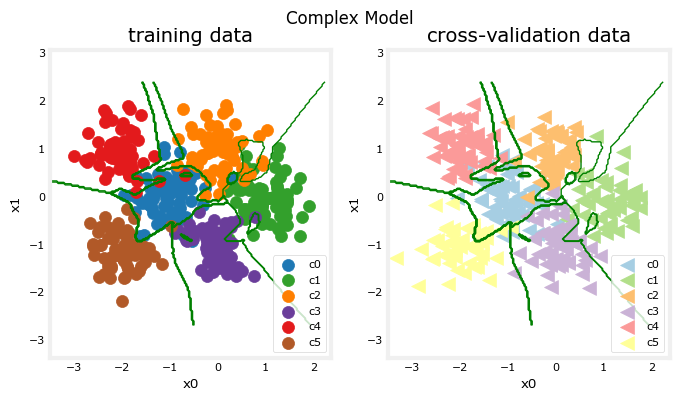

In [24]:
#make a model for plotting routines to call
model_predict = lambda Xl: np.argmax(tf.nn.softmax(model.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict,X_train,y_train, classes, X_cv, y_cv, suptitle="Complex Model")

This model has worked very hard to capture outliers of each category. As a result, it has miscategorized some of the cross-validation data. Let's calculate the classification error.

In [25]:
training_cerr_complex = eval_cat_err(y_train, model_predict(X_train))
cv_cerr_complex = eval_cat_err(y_cv, model_predict(X_cv))
print(f"categorization error, training, complex model: {training_cerr_complex:0.3f}")
print(f"categorization error, cv,       complex model: {cv_cerr_complex:0.3f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
categorization error, training, complex model: 0.005
categorization error, cv,       complex model: 0.119


<a name="5.1"></a>
### 5.1 Simple model
Now, let's try a simple model

<a name="ex04"></a>
### Exercise 4

Below, compose a two-layer model:
* Dense layer with 6 units, relu activation
* Dense layer with 6 units and a linear activation. 
Compile using
* loss with `SparseCategoricalCrossentropy`, remember to use  `from_logits=True`
* Adam optimizer with learning rate of 0.01.

In [26]:
# UNQ_C4
# GRADED CELL: model_s

tf.random.set_seed(1234)
model_s = Sequential(
    [
        ### START CODE HERE ### 
        Dense(units = 6, activation='relu'),
        Dense(units = 6, activation='linear'),       
        ### END CODE HERE ### 
    ], name = "Simple"
)
model_s.compile(
    ### START CODE HERE ### 
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate=0.01),
    ### START CODE HERE ### 
)


In [27]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# BEGIN UNIT TEST
model_s.fit(
    X_train,y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.8353  
Epoch 2/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 1.5550  
Epoch 3/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3627 
Epoch 4/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1828 
Epoch 5/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0047 
Epoch 6/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8324 
Epoch 7/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 0.6782
Epoch 8/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5583 
Epoch 9/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.4720  
Epoch 10/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 0.4106
Epoch 11/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.3663  
Epoch 12/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3342 
Epoch 13/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3101 
Epoch 14/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2911 
Epoch 15/1000
13/13 ━━━━━━━━━━━━━━━━━━━━

In [28]:
# BEGIN UNIT TEST
model_s.summary()

model_s_test(model_s, classes, X_train.shape[1])
# END UNIT TEST

Model: "Simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 6)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │            42 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 182 (1.42 KB)

 Trainable params: 60 (480.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 122 (976.00 B)

ValueError: The layer Simple has never been called and thus has no defined input.

<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
Summary should match this (layer instance names may increment )
```
Model: "Simple"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 6)                 18        
_________________________________________________________________
L2 (Dense)                   (None, 6)                 42        
=================================================================
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________
```
  <details>
  <summary><font size="3" color="darkgreen"><b>Click for more hints</b></font></summary>
  
```python
tf.random.set_seed(1234)
model_s = Sequential(
    [
        Dense(6, activation = 'relu', name="L1"),            # @REPLACE
        Dense(classes, activation = 'linear', name="L2")     # @REPLACE
    ], name = "Simple"
)
model_s.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),     # @REPLACE
    optimizer=tf.keras.optimizers.Adam(0.01),     # @REPLACE
)

model_s.fit(
    X_train,y_train,
    epochs=1000
)                                   
``` 

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 1s 525us/step
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step


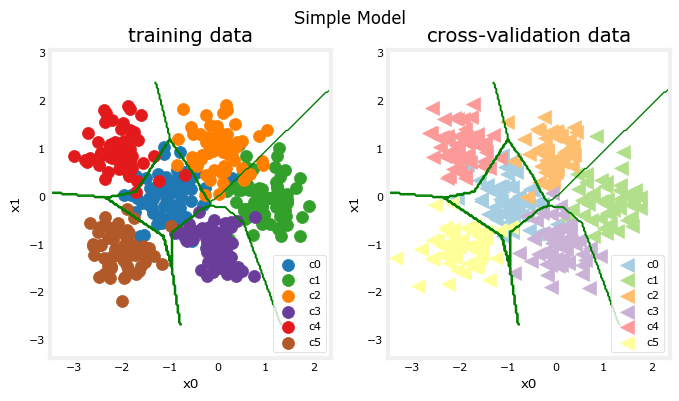

In [29]:
#make a model for plotting routines to call
model_predict_s = lambda Xl: np.argmax(tf.nn.softmax(model_s.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict_s,X_train,y_train, classes, X_cv, y_cv, suptitle="Simple Model")

This simple models does pretty well. Let's calculate the classification error.

In [30]:
training_cerr_simple = eval_cat_err(y_train, model_predict_s(X_train))
cv_cerr_simple = eval_cat_err(y_cv, model_predict_s(X_cv))
print(f"categorization error, training, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
categorization error, training, simple model, 0.062, complex model: 0.005
categorization error, cv,       simple model, 0.066, complex model: 0.119


Our simple model has a little higher classification error on training data but does better on cross-validation data than the more complex model.

<a name="6"></a>
## 6 - Regularization
As in the case of polynomial regression, one can apply regularization to moderate the impact of a more complex model. Let's try this below.

<a name="ex05"></a>
### Exercise 5

Reconstruct your complex model, but this time include regularization.
Below, compose a three-layer model:
* Dense layer with 120 units, relu activation, `kernel_regularizer=tf.keras.regularizers.l2(0.1)`
* Dense layer with 40 units, relu activation, `kernel_regularizer=tf.keras.regularizers.l2(0.1)`
* Dense layer with 6 units and a linear activation. 
Compile using
* loss with `SparseCategoricalCrossentropy`, remember to use  `from_logits=True`
* Adam optimizer with learning rate of 0.01.

In [31]:
# UNQ_C5
# GRADED CELL: model_r

tf.random.set_seed(1234)
model_r = Sequential(
    [
        ### START CODE HERE ### 
        Dense(units = 120, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        Dense(units = 40, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        Dense(units = 6, activation='linear'),
        ### START CODE HERE ### 
    ], name= None
)
model_r.compile(
    ### START CODE HERE ### 
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate=0.01),
    ### START CODE HERE ### 
)


In [32]:
# BEGIN UNIT TEST
model_r.fit(
    X_train, y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.8061  
Epoch 2/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7249 
Epoch 3/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - loss: 1.3256
Epoch 4/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0903 
Epoch 5/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9987 
Epoch 6/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.9445  
Epoch 7/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8978 
Epoch 8/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8652 
Epoch 9/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.8389  
Epoch 10/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - loss: 0.8059
Epoch 11/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step - loss: 0.7725
Epoch 12/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7508 
Epoch 13/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7366 
Epoch 14/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.7253  
Epoch 15/1000
13/13 ━━━━━━━━━━━━━━━━━━━

In [33]:
# BEGIN UNIT TEST
model_r.summary()

model_r_test(model_r, classes, X_train.shape[1]) 
# END UNIT TEST

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 120)            │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 40)             │         4,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           246 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,340 (127.66 KB)

 Trainable params: 5,446 (42.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,894 (85.11 KB)

ddd


ValueError: The layer sequential has never been called and thus has no defined input.

<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
Summary should match this (layer instance names may increment )
```
Model: "ComplexRegularized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 120)               360       
_________________________________________________________________
L2 (Dense)                   (None, 40)                4840      
_________________________________________________________________
L3 (Dense)                   (None, 6)                 246       
=================================================================
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
```
  <details>
  <summary><font size="3" color="darkgreen"><b>Click for more hints</b></font></summary>
  
```python
tf.random.set_seed(1234)
model_r = Sequential(
    [
        Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name="L1"), 
        Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name="L2"),  
        Dense(classes, activation = 'linear', name="L3")  
    ], name="ComplexRegularized"
)
model_r.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(0.01),                             
)

model_r.fit(
    X_train,y_train,
    epochs=1000
)                                   
``` 

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 1s 532us/step
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 1s 471us/step


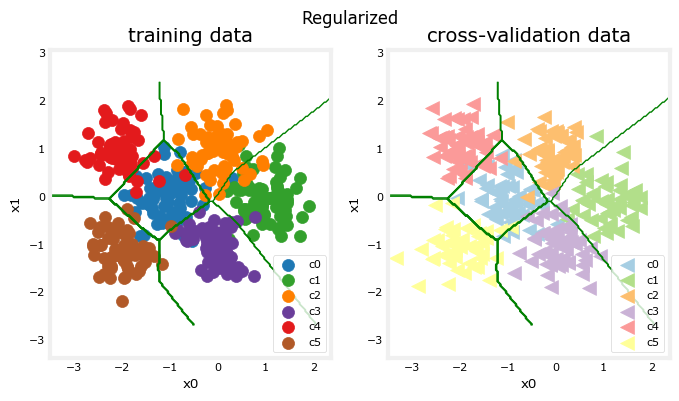

In [34]:
#make a model for plotting routines to call
model_predict_r = lambda Xl: np.argmax(tf.nn.softmax(model_r.predict(Xl)).numpy(),axis=1)
 
plt_nn(model_predict_r, X_train,y_train, classes, X_cv, y_cv, suptitle="Regularized")

The results look very similar to the 'ideal' model. Let's check classification error.

In [35]:
training_cerr_reg = eval_cat_err(y_train, model_predict_r(X_train))
cv_cerr_reg = eval_cat_err(y_cv, model_predict_r(X_cv))
test_cerr_reg = eval_cat_err(y_test, model_predict_r(X_test))
print(f"categorization error, training, regularized: {training_cerr_reg:0.3f}, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       regularized: {cv_cerr_reg:0.3f}, simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
categorization error, training, regularized: 0.077, simple model, 0.062, complex model: 0.005
categorization error, cv,       regularized: 0.069, simple model, 0.066, complex model: 0.119


The simple model is a bit better in the training set than the regularized model but worse in the cross validation set.

<a name="7"></a>
## 7 - Iterate to find optimal regularization value
As you did in linear regression, you can try many regularization values. This code takes several minutes to run. If you have time, you can run it and check the results. If not, you have completed the graded parts of the assignment!

In [36]:
tf.random.set_seed(1234)
lambdas = [0.0, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
models=[None] * len(lambdas)

for i in range(len(lambdas)):
    lambda_ = lambdas[i]
    models[i] =  Sequential(
        [
            Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(classes, activation = 'linear')
        ]
    )
    models[i].compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(0.01),
    )

    models[i].fit(
        X_train,y_train,
        epochs=1000
    )
    print(f"Finished lambda = {lambda_}")


Epoch 1/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4893   
Epoch 2/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4865 
Epoch 3/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3485 
Epoch 4/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 0.2828
Epoch 5/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2443 
Epoch 6/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2210 
Epoch 7/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2137 
Epoch 8/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2068 
Epoch 9/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1968 
Epoch 10/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1946 
Epoch 11/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1926 
Epoch 12/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.1904  
Epoch 13/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1867 
Epoch 14/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step - loss: 0.1864
Epoch 15/1000
13/13 ━━━━━━━━━━━━━━━━━━━

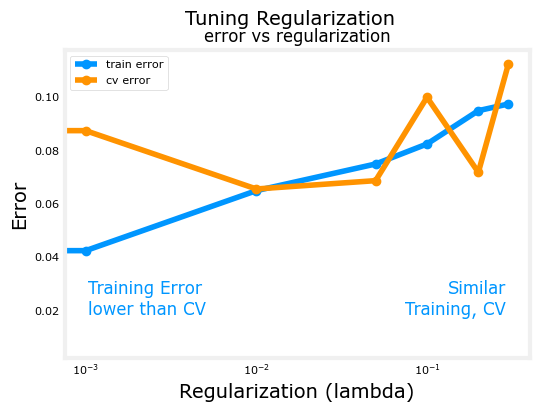

In [38]:
plot_iterate(lambdas, models, X_train, y_train, X_cv, y_cv)

As regularization is increased, the performance of the model on the training and cross-validation data sets converge. For this data set and model, lambda > 0.01 seems to be a reasonable choice.

<a name="7.1"></a>
### 7.1 Test
Let's try our optimized models on the test set and compare them to 'ideal' performance. 

1050/1050 ━━━━━━━━━━━━━━━━━━━━ 1s 467us/step
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


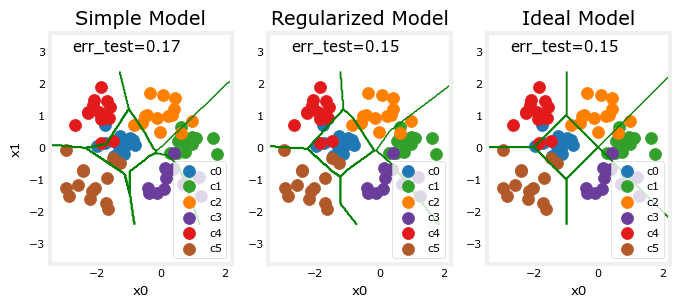

In [37]:
plt_compare(X_test,y_test, classes, model_predict_s, model_predict_r, centers)

Our test set is small and seems to have a number of outliers so classification error is high. However, the performance of our optimized models is comparable to ideal performance.

## Congratulations! 
You have become familiar with important tools to apply when evaluating your machine learning models. Namely:  
* splitting data into trained and untrained sets allows you to differentiate between underfitting and overfitting
* creating three data sets, Training, Cross-Validation and Test allows you to
    * train your parameters $W,B$ with the training set
    * tune model parameters such as complexity, regularization and number of examples with the cross-validation set
    * evaluate your 'real world' performance using the test set.
* comparing training vs cross-validation performance provides insight into a model's propensity towards overfitting (high variance) or underfitting (high bias)

<details>
  <summary><font size="2" color="darkgreen"><b>Please click here if you want to experiment with any of the non-graded code.</b></font></summary>
    <p><i><b>Important Note: Please only do this when you've already passed the assignment to avoid problems with the autograder.</b></i>
    <ol>
        <li> On the notebook’s menu, click “View” > “Cell Toolbar” > “Edit Metadata”</li>
        <li> Hit the “Edit Metadata” button next to the code cell which you want to lock/unlock</li>
        <li> Set the attribute value for “editable” to:
            <ul>
                <li> “true” if you want to unlock it </li>
                <li> “false” if you want to lock it </li>
            </ul>
        </li>
        <li> On the notebook’s menu, click “View” > “Cell Toolbar” > “None” </li>
    </ol>
    <p> Here's a short demo of how to do the steps above: 
        <br>
        <img src="https://lh3.google.com/u/0/d/14Xy_Mb17CZVgzVAgq7NCjMVBvSae3xO1" align="center" alt="unlock_cells.gif">
</details>